# Regression Models
#### The regression models below use our model's results to produce the intended product: a generator to generate an in-game room setup based on the dimensions of the room and the location of the door.
#### The setup includes multiple tables and chairs predicted with the regression models.


### Categorising the Dataset
##### After obtaining the results of the object detection from the MR-CNN model, we categorise the results. We use the door, table and chair class results and organise them in a dataset for further processing.

### Predicting the Tables
##### From the dataset, we use the door, table and chair locations to predict new room setups based on a given door location. In the first step, we generate multiple tables based on a location of the door, which is on the edge of the room.

In [33]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

# Create a sample dataset with 3 rooms
# Each room has a door on the left edge (x=0) and 2 tables at random locations
# The room width and height are also random
# The first 4 columns represent the input features (door_x, door_y, room_width, room_height)
# The last 4 columns represent the target variables (table_1_x, table_1_y, table_2_x, table_2_y)
dataset = np.zeros((3, 8))
for i in range(3):
    door_y = np.random.randint(0, 100)
    room_width = np.random.randint(100, 200)
    room_height = np.random.randint(100, 200)
    dataset[i, 0] = 0 # door_x is always 0
    dataset[i, 1] = door_y
    dataset[i, 2] = room_width
    dataset[i, 3] = room_height
    for j in range(2):
        table_x = np.random.randint(50, room_width - 50)
        table_y = np.random.randint(50, room_height - 50)
        dataset[i, j*2+4] = table_x
        dataset[i, j*2+5] = table_y

# Train a random forest regressor with MultiOutputRegressor
x_train = dataset[:, :4]
y_train = dataset[:, 4:]
regr = RandomForestRegressor()
multi_regressor = MultiOutputRegressor(regr)
multi_regressor.fit(x_train, y_train)

# Predict the coordinates of tables in a new room
new_room = np.array([[0, 0, 150, 150]]) # door_x, door_y, room_width, room_height
table_location = np.round(multi_regressor.predict(new_room)).astype(int)
print(table_location[0])


[59 67 75 70]


### Predicting the Chairs
##### Using the table locations we have predicted above for each room, we predict one chair location for each table, to represent an actual chair in the in-game room setup.

In [34]:
from sklearn.linear_model import LinearRegression
chair_table = np.array([[(1, 2), (4, 5)],
                    [(2, 3), (6, 7),],
                    [(3, 4), (8, 9)],
                    [(4, 5), (10, 11)],
                    [(5, 6), (12, 13)]])
chair_locations = chair_table[:, 0]
table_locations = chair_table[:, 1]
model_table_to_chair = LinearRegression()
model_table_to_chair.fit(table_locations, chair_locations)

#print(table_location)
#print(table_location[:2])
predicted_chair_locations = [model_table_to_chair.predict(table_location[0][:2].reshape(1, -1))[0],
                             model_table_to_chair.predict(table_location[0][2:].reshape(1, -1))[0]]
print(predicted_chair_locations)

[array([30.25, 31.25]), array([35., 36.])]


### Visualisation
##### We plot our results on a graph for a better visual understanding.

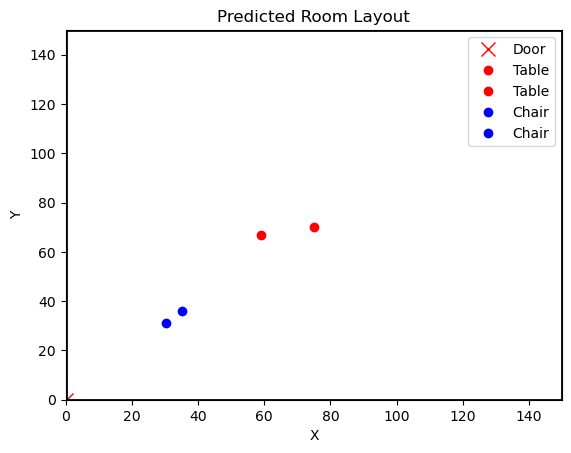

In [35]:
import matplotlib.pyplot as plt

# Plot the new room
fig, ax = plt.subplots()
door_x = new_room[0, 0]
door_y = new_room[0, 1]
room_width = new_room[0, 2]
room_height = new_room[0, 3]
ax.plot([door_x], [door_y], 'rx', markersize=10, label='Door')
ax.plot([0, room_width], [0, 0], 'k-', linewidth=2)
ax.plot([0, room_width], [room_height, room_height], 'k-', linewidth=2)
ax.plot([0, 0], [0, room_height], 'k-', linewidth=2)
ax.plot([room_width, room_width], [0, room_height], 'k-', linewidth=2)
ax.set_xlim([0, door_x + room_width])
ax.set_ylim([0, room_height])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Predicted Room Layout')

# Plot the predicted table locations
for i in range(table_location.shape[1] // 2):
    table_x = table_location[0, i*2]
    table_y = table_location[0, i*2+1]
    ax.plot(table_x, table_y, 'ro', label='Table')
for i in range(len(predicted_chair_locations)):
    chair_x = predicted_chair_locations[i][0]
    chair_y = predicted_chair_locations[i][1]
    ax.plot(chair_x, chair_y, 'bo', label='Chair')

ax.legend()
plt.show()
